# Lab 11 Decision Trees
This lab is based off the following two repositories [1](https://github.com/zziz/cart) and [2](https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L06/code/06-trees_demo.ipynb)

In this lab we will implement the CART algorithm to train decision trees. This is a greedy heuristic algorithm that does not guarantee optimal decision trees. sklearn has a version of CART

In [111]:
!pip install mlxtend
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import tree as sktree
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

In [103]:
class CART(object):
    def __init__(self, tree = 'cls', criterion = 'gini', prune = 'depth', max_depth = 4, min_criterion = 0.05):
        self.feature = None
        self.label = None
        self.n_samples = None
        self.gain = None
        self.left = None
        self.right = None
        self.threshold = None
        self.depth = 0

        self.root = None
        self.criterion = criterion
        self.prune = prune
        self.max_depth = max_depth
        self.min_criterion = min_criterion
        self.tree = tree

    def fit(self, features, target):
        self.root = CART()
        if(self.tree == 'cls'):
            self.root._grow_tree(features, target, self.criterion)
        else:
            self.root._grow_tree(features, target, 'mse')
        self.root._prune(self.prune, self.max_depth, self.min_criterion, self.root.n_samples)

    def predict(self, features):
        return np.array([self.root._predict(f) for f in features])

    def print_tree(self):
        self.root._show_tree(0, ' ')

    def _grow_tree(self, features, target, criterion = 'gini'):
        self.n_samples = features.shape[0] 

        if len(np.unique(target)) == 1:
            self.label = target[0]
            return

        best_gain = 0.0
        best_feature = None
        best_threshold = None

        #select the most frequently occuring class to be the label
        self.label = max([(c, len(target[target == c])) for c in np.unique(target)], key = lambda x : x[1])[0]


        impurity_node = self._calc_impurity(criterion, target)
        
        #evaluate all candidate splits
        for col in range(features.shape[1]):
            feature_level = np.unique(features[:,col])
            #thresholds are the midpoints between the observed feature values
            thresholds = (feature_level[:-1] + feature_level[1:]) / 2.0

            for threshold in thresholds:
                
                ############### Fill in #############
                #Calculate the target, impurity and p of the left and right child nodes if this candidate split were to be made
                target_l = None
                impurity_l = None
                p_l = None

                target_r = None
                impurity_r = None
                p_r = None

                impurity_gain = None 
                ############### Fill in #############
                if impurity_gain > best_gain:
                    best_gain = impurity_gain
                    best_feature = col
                    best_threshold = threshold

        self.feature = best_feature
        self.gain = best_gain
        self.threshold = best_threshold
        if best_gain>0:
            self._split_tree(features, target, criterion)

    def _split_tree(self, features, target, criterion):
        features_l = features[features[:, self.feature] <= self.threshold]
        target_l = target[features[:, self.feature] <= self.threshold]
        self.left = CART()
        self.left.depth = self.depth + 1
        self.left._grow_tree(features_l, target_l, criterion)

        features_r = features[features[:, self.feature] > self.threshold]
        target_r = target[features[:, self.feature] > self.threshold]
        self.right = CART()
        self.right.depth = self.depth + 1
        self.right._grow_tree(features_r, target_r, criterion)

    def _calc_impurity(self, criterion, target):
        if criterion == 'gini':
            return 1.0 - sum([(float(len(target[target == c])) / float(target.shape[0])) ** 2.0 for c in np.unique(target)])
        elif criterion == 'mse':
            return np.mean((target - np.mean(target)) ** 2.0)
        else:
            entropy = 0.0
            for c in np.unique(target):
                p = float(len(target[target == c])) / target.shape[0]
                if p > 0.0:
                    entropy -= p * np.log2(p)
            return entropy            

    def _prune(self, method, max_depth, min_criterion, n_samples):
        if self.feature is None:
            return

        self.left._prune(method, max_depth, min_criterion, n_samples)
        self.right._prune(method, max_depth, min_criterion, n_samples)

        pruning = False

        if method == 'impurity' and self.left.feature is None and self.right.feature is None: 
            if (self.gain * float(self.n_samples) / n_samples) < min_criterion:
                pruning = True
        elif method == 'depth' and self.depth >= max_depth:
            pruning = True

        if pruning is True:
            self.left = None
            self.right = None
            self.feature = None

    def _predict(self, d):
        if self.feature != None:
            if d[self.feature] <= self.threshold:
                return self.left._predict(d)
            else:
                return self.right._predict(d)
        else: 
            return self.label

    def _show_tree(self, depth, cond):
        base = '    ' * depth + cond
        if self.feature != None:
            print(base + 'if X[' + str(self.feature) + '] <= ' + str(self.threshold))
            self.left._show_tree(depth+1, 'then ')
            self.right._show_tree(depth+1, 'else ')
        else:
            print(base + '{value: ' + str(self.label) + ', samples: ' + str(self.n_samples) + '}')

In [104]:


print('\n\nClassification Tree With Entropy Criterion')
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

cls = CART(tree = 'cls', criterion = 'entropy', prune = 'depth', max_depth = 3)
cls.fit(X_train, y_train)
#cls.print_tree()

pred = cls.predict(X_test)
print("This Classification Tree Prediction Accuracy:    {}".format(sum(pred == y_test) / len(pred)))

clf = sktree.DecisionTreeClassifier(criterion = 'entropy', max_depth=3)
clf = clf.fit(X_train, y_train)
sk_pred = clf.predict(X_test)

print("Sklearn Library Tree Prediction Accuracy:        {}".format(sum(sk_pred == y_test) / len(pred)))



Classification Tree With Entropy Criterion
This Classification Tree Prediction Accuracy:    0.9736842105263158
Sklearn Library Tree Prediction Accuracy:        0.9736842105263158


Using the Gini criterion instead:

In [105]:
print('\n\nClassification Tree With Gini Criterion')
cls = CART(tree = 'cls', criterion = 'gini', prune = 'depth', max_depth = 3,min_criterion=0)
cls.fit(X_train, y_train)
#cls.print_tree()

pred = cls.predict(X_test)
print("This Classification Tree Prediction Accuracy:    {}".format(sum(pred == y_test) / len(pred)))

clf = sktree.DecisionTreeClassifier(criterion = 'gini', max_depth=3)
clf = clf.fit(X_train, y_train)
sk_pred = clf.predict(X_test)

print("Sklearn Library Tree Prediction Accuracy:        {}".format(sum(sk_pred == y_test) / len(pred)))



Classification Tree With Gini Criterion
This Classification Tree Prediction Accuracy:    1.0
Sklearn Library Tree Prediction Accuracy:        1.0


# Visualizing the decision boundary

In [108]:
X_new = X[:,[2,3]] #reduce feature set to 2 dimensions for visualizations

X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state = 42)

cls = CART(tree = 'cls', criterion = 'entropy', prune = 'depth', max_depth = 3)
cls.fit(X_train, y_train)
cls.print_tree()

pred = cls.predict(X_test)
print("This Classification Tree Prediction Accuracy:    {}".format(sum(pred == y_test) / len(pred)))

clf = sktree.DecisionTreeClassifier(criterion = 'entropy',max_depth=3)
clf = clf.fit(X_train, y_train)
sk_pred = clf.predict(X_test)
print("Sklearn Library Tree Prediction Accuracy:        {}".format(sum(sk_pred == y_test) / len(pred)))

 if X[0] <= 2.45
    then {value: 0, samples: 35}
    else if X[0] <= 4.75
        then if X[1] <= 1.65
            then {value: 1, samples: 34}
            else {value: 2, samples: 1}
        else if X[0] <= 5.15
            then {value: 2, samples: 16}
            else {value: 2, samples: 26}
This Classification Tree Prediction Accuracy:    0.9736842105263158
Sklearn Library Tree Prediction Accuracy:        0.9736842105263158


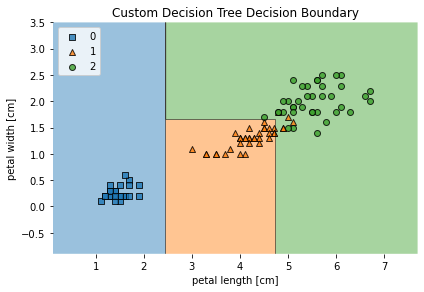

In [115]:


plot_decision_regions(X_train, y_train,cls)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.title("Custom Decision Tree Decision Boundary")
plt.show()

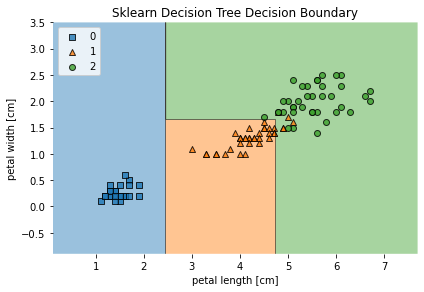

In [116]:
plot_decision_regions(X_train, y_train,clf)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.title("Sklearn Decision Tree Decision Boundary")
plt.show()